# Imports

In [1]:
import torch
import torch.nn as nn

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
from ratinabox.Environment import Environment
from ratinabox.Agent import Agent

In [4]:
import torchtune.modules

In [7]:
from torchtune.modules import RotaryPositionalEmbeddings

## main func

In [2]:
def main(minutes: int = 5,
         start_pos: np.array = [0.5, 0.5],
         getDF: bool = True):

    Env = Environment()
    Ag = Agent(Env)

    # agent configs
    Ag.pos = start_pos
    Ag.thigmotaxis = 0.2

    for i in range(int(minutes*60/Ag.dt)):
        Ag.update()
    explode_columns = ['pos', 'vel', 'head_direction']
    keep_columns = ['t', 'distance_travelled', 'rot_vel']

    if getDF:
        dfaux = pd.DataFrame(Ag.history)
        dfe = dfaux.explode(explode_columns, ignore_index=True)

        y_pos = [val for val in dfe[['pos']].values[1::2]]
        x_pos = [val for val in dfe[['pos']].values[0::2]]

        y_vel = [val for val in dfe[['vel']].values[1::2]]
        x_vel = [val for val in dfe[['vel']].values[0::2]]

        y_head_direction = [val for val in dfe[['head_direction']].values[1::2]]
        x_head_direction = [val for val in dfe[['head_direction']].values[0::2]]

        df = dfaux[keep_columns].copy()

        df['x_pos'] = [val[0] for val in x_pos]
        df['y_pos'] = [val[0] for val in y_pos]

        df['x_vel'] = [val[0] for val in x_vel]
        df['y_vel'] = [val[0] for val in y_vel]

        df['x_head_direction'] = [val[0] for val in x_head_direction]
        df['y_head_direction'] = [val[0] for val in y_head_direction]

        return df, Ag
    else:
        return Ag.history, Ag

In [3]:
df, ag = main(20)
df.head()

,t,distance_travelled,rot_vel,x_pos,y_pos,x_vel,y_vel,x_head_direction,y_head_direction
0,0.1,0.008398,8.238164,0.503118,0.492202,0.031175,-0.077975,0.112810,-0.993617
1,0.2,0.015526,4.240318,0.508253,0.487259,0.051350,-0.049437,0.546502,-0.837458
2,0.3,0.019948,-4.154642,0.509929,0.483167,0.016769,-0.040922,0.436684,-0.899615
3,0.4,0.028410,1.377108,0.514183,0.475851,0.042532,-0.073156,0.480936,-0.876755
4,0.5,0.033971,1.888383,0.517830,0.471654,0.036477,-0.041972,0.600665,-0.799501


    • To AUTOMATICALLY save all plots (recommended), set  `ratinabox.autosave_plots = True`
    • To MANUALLY save plots, call                        `ratinabox.utils.save_figure(figure_object, save_title).
      This warning will not be shown again
HINT: You can stylize plots to make them look like repo/paper by calling `ratinabox.stylize_plots()`
      This hint will not be shown again


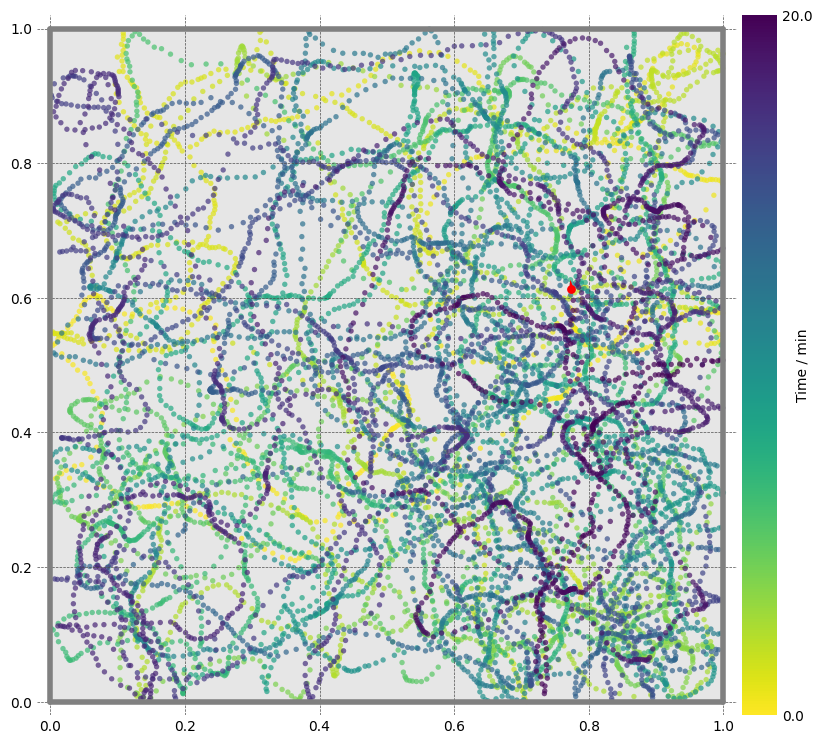

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(14,7))
ax = ag.plot_trajectory(color='changing', colorbar=True, gridlines=True,fig=fig, ax=ax)
plt.show()

In [47]:
df.shape

(12000, 9)

In [159]:
import os
os.getcwd()

'/home/mgteus/workspace/neuro/transformers_andrej'

In [ ]:
# df.to_parquet(r'/home/mgteus/workspace/neuro/transformers_andrej/train_run.gzip')

# Dataset

### data array

In [6]:
feature_array = []
for x_pos,y_pos in zip(df['x_pos'], df['y_pos']):
        feature_array.append(torch.tensor([x_pos, y_pos]))

feature_array = np.array(feature_array)
feature_array = torch.tensor(feature_array)

In [7]:
feature_array[:1], feature_array.shape

(tensor([[0.5031, 0.4922]]), torch.Size([12000, 2]))

In [8]:
n = int(len(df)*0.8)
x_train = feature_array[:n]

x_test = feature_array[n:]


print(f"{x_train.shape=}", f"{x_test.shape=}")

x_train.shape=torch.Size([9600, 2]) x_test.shape=torch.Size([2400, 2])


In [9]:
x_train[0], x_train[0].shape

(tensor([0.5031, 0.4922]), torch.Size([2]))

In [10]:
x_test[0], x_test[0].shape

(tensor([0.6538, 0.3137]), torch.Size([2]))

## train configs

In [11]:
block_size = 5 # 0.5s atras  #MUDAR PRA 10 depois (1s)

x_train[:block_size+1]

tensor([[0.5031, 0.4922],
        [0.5083, 0.4873],
        [0.5099, 0.4832],
        [0.5142, 0.4759],
        [0.5178, 0.4717],
        [0.5216, 0.4687]])

## Example Loop

In [12]:
df.head()

,t,distance_travelled,rot_vel,x_pos,y_pos,x_vel,y_vel,x_head_direction,y_head_direction
0,0.1,0.008398,8.238164,0.503118,0.492202,0.031175,-0.077975,0.112810,-0.993617
1,0.2,0.015526,4.240318,0.508253,0.487259,0.051350,-0.049437,0.546502,-0.837458
2,0.3,0.019948,-4.154642,0.509929,0.483167,0.016769,-0.040922,0.436684,-0.899615
3,0.4,0.028410,1.377108,0.514183,0.475851,0.042532,-0.073156,0.480936,-0.876755
4,0.5,0.033971,1.888383,0.517830,0.471654,0.036477,-0.041972,0.600665,-0.799501


In [13]:
x_exemple = x_train[:block_size]
y_example = x_train[1:block_size+1]
for t in range(block_size):
    context = x_exemple[:t+1]
    target = y_example[t]
    print(f"when input is:", context)
    print('the target: ', target)

when input is: tensor([[0.5031, 0.4922]])
the target:  tensor([0.5083, 0.4873])
when input is: tensor([[0.5031, 0.4922],
        [0.5083, 0.4873]])
the target:  tensor([0.5099, 0.4832])
when input is: tensor([[0.5031, 0.4922],
        [0.5083, 0.4873],
        [0.5099, 0.4832]])
the target:  tensor([0.5142, 0.4759])
when input is: tensor([[0.5031, 0.4922],
        [0.5083, 0.4873],
        [0.5099, 0.4832],
        [0.5142, 0.4759]])
the target:  tensor([0.5178, 0.4717])
when input is: tensor([[0.5031, 0.4922],
        [0.5083, 0.4873],
        [0.5099, 0.4832],
        [0.5142, 0.4759],
        [0.5178, 0.4717]])
the target:  tensor([0.5216, 0.4687])


# Building Blocks

In [14]:
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 10 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = x_train if split == 'train' else x_test
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

In [15]:
def get_batch2(split):
    # generate a small batch of data of inputs x and targets y
    data = x_train if split == 'train' else x_test
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1] for i in ix])
    return x, y

In [16]:
xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)
print('----')

inputs:
torch.Size([4, 10, 2])
tensor([[[0.5127, 0.3658],
         [0.5198, 0.3523],
         [0.5249, 0.3397],
         [0.5321, 0.3215],
         [0.5438, 0.3082],
         [0.5557, 0.2985],
         [0.5615, 0.2890],
         [0.5748, 0.2757],
         [0.5943, 0.2651],
         [0.6140, 0.2531]],

        [[0.9343, 0.5113],
         [0.9321, 0.5134],
         [0.9296, 0.5148],
         [0.9253, 0.5196],
         [0.9198, 0.5258],
         [0.9132, 0.5313],
         [0.9112, 0.5390],
         [0.9072, 0.5488],
         [0.9010, 0.5665],
         [0.8941, 0.5803]],

        [[0.7323, 0.5275],
         [0.7393, 0.5416],
         [0.7465, 0.5491],
         [0.7528, 0.5621],
         [0.7592, 0.5753],
         [0.7721, 0.5851],
         [0.7902, 0.5913],
         [0.8056, 0.5969],
         [0.8255, 0.5916],
         [0.8471, 0.5929]],

        [[0.1487, 0.2150],
         [0.1298, 0.2199],
         [0.1132, 0.2320],
         [0.0966, 0.2391],
         [0.0828, 0.2439],
         [0.0670, 

In [163]:
xb, yb = get_batch2('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)
print('----')

inputs:
torch.Size([4, 10, 2])
tensor([[[0.4065, 0.1582],
         [0.3961, 0.1680],
         [0.3880, 0.1805],
         [0.3712, 0.1857],
         [0.3587, 0.1910],
         [0.3537, 0.1987],
         [0.3514, 0.2052],
         [0.3487, 0.2122],
         [0.3461, 0.2171],
         [0.3436, 0.2219]],

        [[0.6440, 0.3458],
         [0.6388, 0.3448],
         [0.6292, 0.3393],
         [0.6190, 0.3330],
         [0.6146, 0.3179],
         [0.6104, 0.3054],
         [0.6059, 0.2966],
         [0.6019, 0.2921],
         [0.5981, 0.2858],
         [0.5938, 0.2769]],

        [[0.2850, 0.4189],
         [0.2908, 0.4150],
         [0.2954, 0.4155],
         [0.2990, 0.4158],
         [0.3021, 0.4162],
         [0.3097, 0.4163],
         [0.3161, 0.4184],
         [0.3256, 0.4194],
         [0.3393, 0.4211],
         [0.3509, 0.4209]],

        [[0.6991, 0.4050],
         [0.7188, 0.4041],
         [0.7341, 0.4002],
         [0.7485, 0.3984],
         [0.7624, 0.3965],
         [0.7749, 

In [17]:
torch.tensor([0.55])[:]

tensor([0.5500])

In [18]:
for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

when input is [[0.5127149820327759, 0.36580196022987366]] the target: tensor([0.5198, 0.3523])
when input is [[0.5127149820327759, 0.36580196022987366], [0.5198267102241516, 0.3522854447364807]] the target: tensor([0.5249, 0.3397])
when input is [[0.5127149820327759, 0.36580196022987366], [0.5198267102241516, 0.3522854447364807], [0.524946928024292, 0.3396902084350586]] the target: tensor([0.5321, 0.3215])
when input is [[0.5127149820327759, 0.36580196022987366], [0.5198267102241516, 0.3522854447364807], [0.524946928024292, 0.3396902084350586], [0.5320912599563599, 0.3215034306049347]] the target: tensor([0.5438, 0.3082])
when input is [[0.5127149820327759, 0.36580196022987366], [0.5198267102241516, 0.3522854447364807], [0.524946928024292, 0.3396902084350586], [0.5320912599563599, 0.3215034306049347], [0.5438470244407654, 0.3082059919834137]] the target: tensor([0.5557, 0.2985])
when input is [[0.5127149820327759, 0.36580196022987366], [0.5198267102241516, 0.3522854447364807], [0.52494

## attention mechanism

In [19]:
torch.manual_seed(1337)

F, L, C = 4, 8, 32 # # de (F)olhas,  # de (L)inhas e # de (C)olunas
head_size = 16

In [20]:
x = x_train[:F*L*C].reshape(F, L, C, 2)
print(x.shape)
x[0, 0, 0,]

torch.Size([4, 8, 32, 2])


tensor([0.5031, 0.4922])

In [21]:
two_linear = nn.Linear(2, 1, bias=False)

two_linear(x[0, 0, 0,])

tensor([-0.3031], grad_fn=<SqueezeBackward4>)

In [22]:
two_linear(x).shape, two_linear(x).reshape(F, L, C).shape

(torch.Size([4, 8, 32, 1]), torch.Size([4, 8, 32]))

In [23]:
x_ = two_linear(x).reshape(F, L, C)

###  k, q linears

In [24]:
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)

In [25]:
k = key(x_)
q = query(x_)

In [26]:
k.shape, k.transpose(-2, -1).shape

(torch.Size([4, 8, 16]), torch.Size([4, 16, 8]))

In [27]:
# Vamos trocar a segunda com a terceira dimensao da matriz de keys para conseguirmos multiplicar as duas

In [28]:
wei_no_head_norm = q @ k.transpose(-2, -1) # (F, L, head_size) @ (F, head_size, L) => (F, L, L)
wei_head_norm = q @ k.transpose(-2, -1) * head_size **-0.5 # normalizando os pesos ( deixando a da multiplicacao menor que de cada matriz k e q)

wei = q @ k.transpose(-2, -1) * head_size **-0.5
wei.shape

torch.Size([4, 8, 8])

In [29]:
f"{k.var(), q.var(), wei_no_head_norm.var()}", f"{k.var(), q.var(), wei_head_norm.var()}"

('(tensor(0.0420, grad_fn=<VarBackward0>), tensor(0.0510, grad_fn=<VarBackward0>), tensor(0.0097, grad_fn=<VarBackward0>))',
 '(tensor(0.0420, grad_fn=<VarBackward0>), tensor(0.0510, grad_fn=<VarBackward0>), tensor(0.0006, grad_fn=<VarBackward0>))')

In [30]:
wei[0,:,:]

tensor([[-0.0246, -0.0216, -0.0042, -0.0026, -0.0103, -0.0180, -0.0344, -0.0452],
        [-0.0218, -0.0180, -0.0033, -0.0024, -0.0099, -0.0173, -0.0310, -0.0400],
        [-0.0028, -0.0021, -0.0005, -0.0006, -0.0013, -0.0026, -0.0042, -0.0051],
        [ 0.0017,  0.0003, -0.0001,  0.0003,  0.0014,  0.0027,  0.0029,  0.0032],
        [-0.0088, -0.0086, -0.0018, -0.0009, -0.0031, -0.0053, -0.0118, -0.0161],
        [-0.0116, -0.0132, -0.0031, -0.0011, -0.0030, -0.0049, -0.0150, -0.0213],
        [-0.0291, -0.0272, -0.0056, -0.0032, -0.0112, -0.0195, -0.0402, -0.0535],
        [-0.0452, -0.0400, -0.0078, -0.0046, -0.0187, -0.0324, -0.0629, -0.0829]],
       grad_fn=<SliceBackward0>)

In [31]:
tril = torch.tril(torch.ones(L, L))
tril

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])

In [32]:
tril.shape

torch.Size([8, 8])

In [33]:
wei_masked = wei.masked_fill(tril == 0, float('-inf'))
wei.masked_fill(tril == 0, float('-inf'))[0,:,:]

tensor([[-0.0246,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
        [-0.0218, -0.0180,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
        [-0.0028, -0.0021, -0.0005,    -inf,    -inf,    -inf,    -inf,    -inf],
        [ 0.0017,  0.0003, -0.0001,  0.0003,    -inf,    -inf,    -inf,    -inf],
        [-0.0088, -0.0086, -0.0018, -0.0009, -0.0031,    -inf,    -inf,    -inf],
        [-0.0116, -0.0132, -0.0031, -0.0011, -0.0030, -0.0049,    -inf,    -inf],
        [-0.0291, -0.0272, -0.0056, -0.0032, -0.0112, -0.0195, -0.0402,    -inf],
        [-0.0452, -0.0400, -0.0078, -0.0046, -0.0187, -0.0324, -0.0629, -0.0829]],
       grad_fn=<SliceBackward0>)

In [34]:
nn.functional.softmax(wei, dim=1)[0,:,:]

tensor([[0.1241, 0.1243, 0.1249, 0.1249, 0.1246, 0.1243, 0.1238, 0.1234],
        [0.1245, 0.1248, 0.1250, 0.1249, 0.1246, 0.1244, 0.1242, 0.1240],
        [0.1269, 0.1268, 0.1254, 0.1252, 0.1257, 0.1262, 0.1275, 0.1284],
        [0.1274, 0.1271, 0.1254, 0.1253, 0.1261, 0.1269, 0.1285, 0.1295],
        [0.1261, 0.1260, 0.1252, 0.1251, 0.1255, 0.1258, 0.1266, 0.1270],
        [0.1258, 0.1254, 0.1250, 0.1251, 0.1255, 0.1259, 0.1262, 0.1264],
        [0.1236, 0.1236, 0.1247, 0.1248, 0.1245, 0.1241, 0.1230, 0.1224],
        [0.1216, 0.1221, 0.1244, 0.1247, 0.1235, 0.1225, 0.1203, 0.1188]],
       grad_fn=<SliceBackward0>)

In [35]:
wei_masked_softmax = nn.functional.softmax(wei_masked, dim=1)
nn.functional.softmax(wei_masked, dim=1)[0,:,:]

tensor([[0.1241, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1245, 0.1425, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1269, 0.1448, 0.1671, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1274, 0.1451, 0.1672, 0.2004, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1261, 0.1438, 0.1669, 0.2002, 0.2515, 0.0000, 0.0000, 0.0000],
        [0.1258, 0.1432, 0.1667, 0.2002, 0.2515, 0.3380, 0.0000, 0.0000],
        [0.1236, 0.1412, 0.1663, 0.1997, 0.2494, 0.3331, 0.5057, 0.0000],
        [0.1216, 0.1394, 0.1659, 0.1995, 0.2476, 0.3289, 0.4943, 1.0000]],
       grad_fn=<SliceBackward0>)

In [36]:
dropout_value = 0.5
dropout_ = nn.Dropout(dropout_value)

In [37]:
dropout_(wei_masked_softmax)[0,:,:]

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2490, 0.2850, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.2895, 0.3342, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.2903, 0.3343, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.5030, 0.0000, 0.0000, 0.0000],
        [0.2515, 0.2864, 0.3333, 0.0000, 0.5030, 0.6760, 0.0000, 0.0000],
        [0.0000, 0.2824, 0.0000, 0.0000, 0.0000, 0.6663, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.3318, 0.0000, 0.0000, 0.6577, 0.0000, 0.0000]],
       grad_fn=<SliceBackward0>)

In [38]:
wei_masked_softmax_drop = dropout_(wei_masked_softmax)
wei_masked_softmax_drop.shape

torch.Size([4, 8, 8])

In [39]:
v = value(x_)
v.shape

torch.Size([4, 8, 16])

In [40]:
# out
view_out = wei_masked_softmax_drop @ v
view_out.shape

torch.Size([4, 8, 16])

In [41]:
view_out[0,:,:]

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0099, -0.0566, -0.0262, -0.0287,  0.0027,  0.0245,  0.0205, -0.0152,
         -0.0320,  0.0374, -0.0300,  0.0059,  0.0211,  0.0279,  0.0281,  0.0168],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0148, -0.1514, -0.0485, -0.0694, -0.0027,  0.0543,  0.0232, -0.0267,
         -0.0703,  0.0928, -0.0685,  0.0145,  0.0491,  0.0592,  0.0579,  0.0423],
        [ 0.0009, -0.2030, -0.0344, -0.0863, -0.0179,  0.0557, -0.0163, -0.0143,
         -0.0691,  0.1133, -0.0780,  0.0200,  0.0554,  0.0563,  0.0538,  0.0532],
        [ 0.0162, -0.1397, -0.0296, -0.0664, -0.0036,  0.0444, -0.0041, -0.0158,
         -0.0563,  0.0781, -0.0452,  0.0076,  0.0258,  0.0392,  0.0325,  0.0329],
        [ 0.0254, -0.4

In [42]:
out = wei_masked_softmax_drop @ v

In [43]:
C

32

In [44]:
ff_lin1 = nn.Linear(C//2, 2*C)
ff_relu = nn.ReLU()
ff_lin2 = nn.Linear(2*C, C//2)
ff_drop = nn.Dropout(dropout_value)

In [45]:
print(ff_lin1(out).shape)
out_lin1 = ff_lin1(out)
ff_lin1(out)[0,0,:]

torch.Size([4, 8, 64])


tensor([-0.1801,  0.0553, -0.0610,  0.0404, -0.1188,  0.2139,  0.0056, -0.2126,
         0.1208, -0.0746,  0.2207, -0.0422, -0.0533, -0.1881, -0.0354, -0.2360,
         0.1720,  0.0206, -0.2028,  0.1968,  0.1179,  0.1694,  0.1733,  0.2318,
        -0.1992, -0.0785, -0.0104,  0.1766,  0.0843, -0.0037,  0.2125, -0.2124,
        -0.0157, -0.1736,  0.0066, -0.0689, -0.1467, -0.2209,  0.1080, -0.1106,
        -0.2322,  0.0125,  0.1933,  0.1106,  0.0777, -0.2089, -0.1196, -0.2015,
         0.2255, -0.1632, -0.1020,  0.0665, -0.0222, -0.1960,  0.1854, -0.0833,
        -0.1890, -0.1513,  0.0144,  0.0007, -0.0638,  0.1689,  0.1967,  0.1962],
       grad_fn=<SliceBackward0>)

In [46]:
print(ff_relu(out_lin1).shape)
out_lin1_relu = ff_relu(out_lin1)
ff_relu(out_lin1)[0,0,:]

torch.Size([4, 8, 64])


tensor([0.0000, 0.0553, 0.0000, 0.0404, 0.0000, 0.2139, 0.0056, 0.0000, 0.1208,
        0.0000, 0.2207, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1720, 0.0206,
        0.0000, 0.1968, 0.1179, 0.1694, 0.1733, 0.2318, 0.0000, 0.0000, 0.0000,
        0.1766, 0.0843, 0.0000, 0.2125, 0.0000, 0.0000, 0.0000, 0.0066, 0.0000,
        0.0000, 0.0000, 0.1080, 0.0000, 0.0000, 0.0125, 0.1933, 0.1106, 0.0777,
        0.0000, 0.0000, 0.0000, 0.2255, 0.0000, 0.0000, 0.0665, 0.0000, 0.0000,
        0.1854, 0.0000, 0.0000, 0.0000, 0.0144, 0.0007, 0.0000, 0.1689, 0.1967,
        0.1962], grad_fn=<SliceBackward0>)

In [47]:
print(ff_lin2(out_lin1_relu).shape)
out_lin1_relu_lin2 = ff_lin2(out_lin1_relu)
ff_lin2(out_lin1_relu)[0,0,:]

torch.Size([4, 8, 16])


tensor([ 0.0639,  0.0453,  0.0641,  0.0060,  0.0196,  0.1246, -0.0250,  0.1915,
         0.0197, -0.0874, -0.0392, -0.0280, -0.1177, -0.1133, -0.0208, -0.1193],
       grad_fn=<SliceBackward0>)

In [48]:
print(ff_drop(out_lin1_relu_lin2).shape)
out_lin1_relu_lin2_drop = ff_drop(out_lin1_relu_lin2)
ff_drop(out_lin1_relu_lin2)[0,0,:]

torch.Size([4, 8, 16])


tensor([ 0.1277,  0.0000,  0.1283,  0.0120,  0.0393,  0.0000, -0.0000,  0.3829,
         0.0000, -0.0000, -0.0000, -0.0560, -0.0000, -0.0000, -0.0415, -0.2386],
       grad_fn=<SliceBackward0>)

In [51]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(0.8),
        )

    def forward(self, x):
        return self.net(x)

In [52]:
feedforward = FeedFoward(C)

In [53]:
print(feedforward(out).shape)
feedforward(out)[0,0,:]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x16 and 32x128)

In [54]:
# full copied
class LayerNorm1d: # (used to be BatchNorm1d)

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

  def __call__(self, x):
    # calculate the forward pass
    xmean = x.mean(1, keepdim=True) # batch mean
    xvar = x.var(1, keepdim=True) # batch variance
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

# torch.manual_seed(1337)
# module = LayerNorm1d(100)
# x = torch.randn(32, 100) # batch size 32 of 100-dimensional vectors
# x = module(x)
# x.shape

In [55]:
lay_norm = LayerNorm1d(C//2)

In [56]:
print(lay_norm(out).shape)
lay_norm(out)[0,0,:]

torch.Size([4, 8, 16])


tensor([-1.0346,  1.0355,  1.1973,  1.0524,  0.7012, -1.1025,  0.3549,  1.1143,
         1.1116, -1.0418,  1.1033, -1.0431, -1.1206, -1.1632, -1.1874, -1.0609],
       grad_fn=<SliceBackward0>)

### head class

In [57]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

### block class

In [58]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head, block_size, dropout):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = Head(n_head, head_size, block_size, dropout)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

#### test block class

In [59]:
model = Block(100, 1, 10, 0.0)

TypeError: Head.__init__() takes 2 positional arguments but 5 were given

In [60]:
xb, yb = get_batch('train')

In [61]:
xb.shape

torch.Size([4, 10, 2])

In [62]:
xb

tensor([[[0.4651, 0.1243],
         [0.4751, 0.1165],
         [0.4836, 0.1105],
         [0.4925, 0.1080],
         [0.5000, 0.1016],
         [0.5089, 0.1046],
         [0.5211, 0.1063],
         [0.5284, 0.1120],
         [0.5316, 0.1157],
         [0.5349, 0.1190]],

        [[0.8636, 0.3675],
         [0.8809, 0.3661],
         [0.8903, 0.3619],
         [0.8969, 0.3592],
         [0.9029, 0.3552],
         [0.9102, 0.3530],
         [0.9184, 0.3484],
         [0.9252, 0.3430],
         [0.9302, 0.3419],
         [0.9357, 0.3395]],

        [[0.2192, 0.0716],
         [0.2279, 0.0772],
         [0.2336, 0.0785],
         [0.2375, 0.0770],
         [0.2454, 0.0760],
         [0.2574, 0.0776],
         [0.2667, 0.0819],
         [0.2764, 0.0797],
         [0.2864, 0.0746],
         [0.2982, 0.0740]],

        [[0.3756, 0.2743],
         [0.3785, 0.2736],
         [0.3796, 0.2721],
         [0.3856, 0.2677],
         [0.3956, 0.2671],
         [0.4082, 0.2691],
         [0.4274, 0.27

In [63]:
two_linear(xb)

tensor([[[-0.2781],
         [-0.2840],
         [-0.2891],
         [-0.2943],
         [-0.2988],
         [-0.3041],
         [-0.3114],
         [-0.3158],
         [-0.3177],
         [-0.3197]],

        [[-0.5173],
         [-0.5276],
         [-0.5332],
         [-0.5371],
         [-0.5406],
         [-0.5450],
         [-0.5498],
         [-0.5539],
         [-0.5568],
         [-0.5601]],

        [[-0.1312],
         [-0.1364],
         [-0.1398],
         [-0.1421],
         [-0.1468],
         [-0.1540],
         [-0.1595],
         [-0.1653],
         [-0.1713],
         [-0.1783]],

        [[-0.2257],
         [-0.2274],
         [-0.2281],
         [-0.2316],
         [-0.2376],
         [-0.2451],
         [-0.2566],
         [-0.2706],
         [-0.2831],
         [-0.2925]]], grad_fn=<UnsafeViewBackward0>)

In [65]:
two_linear(xb).squeeze(0).squeeze(1).shape
#.reshape(1, F, L, C)

torch.Size([4, 10, 1])

In [66]:
xb.shape

torch.Size([4, 10, 2])

In [67]:
        #self.four_linear = nn.Linear(4, 1, bias=False) # going from x_hd, y_hd, x_vl, y_vl to one number

# Teste GIT

In [68]:
class Pos(nn.Module):
    def __ini__(self, )

SyntaxError: expected ':' (2559281548.py, line 2)

In [18]:
x = torch.randn(1, 10)
x

tensor([[-0.4310, -0.9309, -0.5432, -0.9664,  1.7877,  0.2564,  0.3814,  0.2147,
          0.2409,  0.4410]])

In [20]:
x.unsqueeze(2).shape

torch.Size([1, 10, 1])

In [69]:
xb, yb = get_batch2('train')

In [70]:
xb.shape

torch.Size([4, 10, 2])

In [71]:
x_ = nn.Linear(2, 1, bias=False)
y_ = nn.Linear(2, 1, bias=False)

lin2_2 = nn.Linear(2, 2, bias=False)
lin2_1 = nn.Linear(2, 1, bias=False)

In [72]:
lin2_2(xb)

tensor([[[ 0.2535, -0.7497],
         [ 0.2513, -0.7433],
         [ 0.2480, -0.7324],
         [ 0.2425, -0.7233],
         [ 0.2373, -0.7110],
         [ 0.2338, -0.7053],
         [ 0.2321, -0.7007],
         [ 0.2309, -0.6957],
         [ 0.2291, -0.6922],
         [ 0.2277, -0.6892]],

        [[ 0.1342, -0.2891],
         [ 0.1371, -0.2969],
         [ 0.1411, -0.3066],
         [ 0.1442, -0.3179],
         [ 0.1475, -0.3286],
         [ 0.1500, -0.3370],
         [ 0.1542, -0.3466],
         [ 0.1573, -0.3504],
         [ 0.1594, -0.3483],
         [ 0.1612, -0.3473]],

        [[ 0.1625, -0.5788],
         [ 0.1633, -0.5814],
         [ 0.1652, -0.5855],
         [ 0.1686, -0.5937],
         [ 0.1709, -0.5984],
         [ 0.1728, -0.6048],
         [ 0.1761, -0.6117],
         [ 0.1783, -0.6204],
         [ 0.1804, -0.6275],
         [ 0.1830, -0.6358]],

        [[ 0.0851, -0.5976],
         [ 0.0845, -0.5948],
         [ 0.0840, -0.5927],
         [ 0.0835, -0.5901],
        

In [73]:
lin2_2(xb).shape

torch.Size([4, 10, 2])

In [74]:
lin2_1(lin2_2(xb))

tensor([[[-0.3072],
         [-0.3045],
         [-0.3001],
         [-0.2966],
         [-0.2917],
         [-0.2895],
         [-0.2876],
         [-0.2855],
         [-0.2841],
         [-0.2830]],

        [[-0.1144],
         [-0.1176],
         [-0.1215],
         [-0.1262],
         [-0.1306],
         [-0.1341],
         [-0.1379],
         [-0.1393],
         [-0.1381],
         [-0.1375]],

        [[-0.2408],
         [-0.2419],
         [-0.2435],
         [-0.2468],
         [-0.2486],
         [-0.2513],
         [-0.2540],
         [-0.2577],
         [-0.2606],
         [-0.2640]],

        [[-0.2578],
         [-0.2566],
         [-0.2557],
         [-0.2546],
         [-0.2537],
         [-0.2526],
         [-0.2519],
         [-0.2509],
         [-0.2502],
         [-0.2484]]], grad_fn=<UnsafeViewBackward0>)

In [75]:
lin2_1(lin2_2(xb)).shape

torch.Size([4, 10, 1])

In [76]:
lin2_1(lin2_2(xb)).squeeze(-1).shape

torch.Size([4, 10])

In [77]:
lin2_1(lin2_2(xb)).squeeze(-1)

tensor([[-0.3072, -0.3045, -0.3001, -0.2966, -0.2917, -0.2895, -0.2876, -0.2855,
         -0.2841, -0.2830],
        [-0.1144, -0.1176, -0.1215, -0.1262, -0.1306, -0.1341, -0.1379, -0.1393,
         -0.1381, -0.1375],
        [-0.2408, -0.2419, -0.2435, -0.2468, -0.2486, -0.2513, -0.2540, -0.2577,
         -0.2606, -0.2640],
        [-0.2578, -0.2566, -0.2557, -0.2546, -0.2537, -0.2526, -0.2519, -0.2509,
         -0.2502, -0.2484]], grad_fn=<SqueezeBackward1>)

In [78]:
aux = lin2_1(lin2_2(xb)).squeeze(-1)

In [79]:
context_length = 10
head_size = context_length//2

In [80]:
xb.shape

torch.Size([4, 10, 2])

In [81]:
xb[0].shape

torch.Size([10, 2])

In [82]:
xb , yb = get_batch('train')

In [83]:
xb[0]

tensor([[0.5682, 0.8246],
        [0.5628, 0.8154],
        [0.5580, 0.8054],
        [0.5511, 0.7940],
        [0.5459, 0.7888],
        [0.5410, 0.7860],
        [0.5362, 0.7836],
        [0.5304, 0.7793],
        [0.5238, 0.7734],
        [0.5204, 0.7683]])

In [84]:
yb[0]

tensor([[0.5628, 0.8154],
        [0.5580, 0.8054],
        [0.5511, 0.7940],
        [0.5459, 0.7888],
        [0.5410, 0.7860],
        [0.5362, 0.7836],
        [0.5304, 0.7793],
        [0.5238, 0.7734],
        [0.5204, 0.7683],
        [0.5165, 0.7636]])

In [140]:
key = nn.Linear(context_length, context_length)
query = nn.Linear(context_length, context_length)
values = nn.Linear(context_length, context_length)

In [ ]:
torch.randint(1, )

In [26]:
query = nn.Linear(2, 2) # 2 = head_size

In [27]:
lin(xb)

tensor([[[ 0.1531,  0.0457],
         [ 0.1536,  0.0419],
         [ 0.1540,  0.0383],
         [ 0.1544,  0.0356],
         [ 0.1547,  0.0342],
         [ 0.1553,  0.0306],
         [ 0.1557,  0.0275],
         [ 0.1563,  0.0222],
         [ 0.1578,  0.0144],
         [ 0.1589,  0.0065]],

        [[ 0.1693,  0.0035],
         [ 0.1694,  0.0041],
         [ 0.1694,  0.0049],
         [ 0.1695,  0.0056],
         [ 0.1696,  0.0064],
         [ 0.1697,  0.0069],
         [ 0.1698,  0.0069],
         [ 0.1699,  0.0069],
         [ 0.1699,  0.0071],
         [ 0.1698,  0.0075]],

        [[ 0.1182,  0.1651],
         [ 0.1189,  0.1624],
         [ 0.1194,  0.1607],
         [ 0.1199,  0.1580],
         [ 0.1207,  0.1543],
         [ 0.1214,  0.1511],
         [ 0.1220,  0.1486],
         [ 0.1224,  0.1463],
         [ 0.1229,  0.1443],
         [ 0.1233,  0.1423]],

        [[ 0.1778, -0.0365],
         [ 0.1774, -0.0364],
         [ 0.1770, -0.0363],
         [ 0.1768, -0.0370],
        

In [28]:
xb @ lin(xb).transpose(-2, -1)

tensor([[[0.0833, 0.0823, 0.0814, 0.0808, 0.0805, 0.0797, 0.0790, 0.0776,
          0.0760, 0.0741],
         [0.0823, 0.0814, 0.0805, 0.0799, 0.0797, 0.0789, 0.0782, 0.0769,
          0.0754, 0.0736],
         [0.0814, 0.0806, 0.0798, 0.0792, 0.0789, 0.0782, 0.0775, 0.0763,
          0.0749, 0.0732],
         [0.0811, 0.0803, 0.0795, 0.0789, 0.0787, 0.0780, 0.0773, 0.0762,
          0.0748, 0.0732],
         [0.0811, 0.0803, 0.0796, 0.0790, 0.0788, 0.0781, 0.0775, 0.0763,
          0.0750, 0.0734],
         [0.0810, 0.0802, 0.0795, 0.0790, 0.0788, 0.0781, 0.0775, 0.0764,
          0.0751, 0.0736],
         [0.0803, 0.0796, 0.0789, 0.0784, 0.0782, 0.0776, 0.0770, 0.0760,
          0.0748, 0.0733],
         [0.0788, 0.0782, 0.0775, 0.0771, 0.0769, 0.0764, 0.0758, 0.0749,
          0.0738, 0.0725],
         [0.0792, 0.0786, 0.0781, 0.0777, 0.0775, 0.0771, 0.0766, 0.0757,
          0.0748, 0.0737],
         [0.0779, 0.0774, 0.0770, 0.0766, 0.0765, 0.0761, 0.0757, 0.0750,
          0.0743,

In [29]:
(xb @ lin(xb).transpose(-2, -1)).shape

torch.Size([4, 10, 10])

In [141]:
aux.shape

torch.Size([4, 10])

In [142]:
k = key(aux)
q = query(aux)
key(aux).shape

torch.Size([4, 10])

In [143]:
k

tensor([[ 0.1028,  0.2044, -0.1600, -0.0681,  0.1336,  0.0350, -0.1849, -0.2155,
         -0.1862, -0.0541],
        [ 0.2162,  0.1937, -0.1422,  0.0337,  0.0949, -0.0327, -0.2185, -0.2552,
         -0.1220, -0.1147],
        [ 0.1414,  0.1936, -0.1568, -0.0330,  0.1095,  0.0200, -0.1891, -0.2266,
         -0.1737, -0.0691],
        [ 0.3045,  0.1689, -0.1342,  0.1128,  0.0356, -0.0708, -0.2249, -0.2808,
         -0.0933, -0.1479]], grad_fn=<AddmmBackward0>)

In [144]:
k.transpose(-2, -1).shape

torch.Size([10, 4])

In [145]:
k.transpose(-2, -1)

tensor([[ 0.1028,  0.2162,  0.1414,  0.3045],
        [ 0.2044,  0.1937,  0.1936,  0.1689],
        [-0.1600, -0.1422, -0.1568, -0.1342],
        [-0.0681,  0.0337, -0.0330,  0.1128],
        [ 0.1336,  0.0949,  0.1095,  0.0356],
        [ 0.0350, -0.0327,  0.0200, -0.0708],
        [-0.1849, -0.2185, -0.1891, -0.2249],
        [-0.2155, -0.2552, -0.2266, -0.2808],
        [-0.1862, -0.1220, -0.1737, -0.0933],
        [-0.0541, -0.1147, -0.0691, -0.1479]], grad_fn=<TransposeBackward0>)

In [146]:
wei = q @ k.transpose(-2, -1)
wei.shape

torch.Size([4, 4])

In [147]:
wei

tensor([[0.2046, 0.2362, 0.2151, 0.2583],
        [0.2537, 0.2918, 0.2670, 0.3191],
        [0.2264, 0.2587, 0.2375, 0.2819],
        [0.3052, 0.3450, 0.3198, 0.3747]], grad_fn=<MmBackward0>)

In [30]:
tril = torch.tril(torch.ones(context_length, context_length))

In [32]:
(xb @ lin(xb).transpose(-2, -1)).masked_fill(tril == 0, float('-inf'))

tensor([[[0.0833,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,
            -inf,   -inf],
         [0.0823, 0.0814,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,
            -inf,   -inf],
         [0.0814, 0.0806, 0.0798,   -inf,   -inf,   -inf,   -inf,   -inf,
            -inf,   -inf],
         [0.0811, 0.0803, 0.0795, 0.0789,   -inf,   -inf,   -inf,   -inf,
            -inf,   -inf],
         [0.0811, 0.0803, 0.0796, 0.0790, 0.0788,   -inf,   -inf,   -inf,
            -inf,   -inf],
         [0.0810, 0.0802, 0.0795, 0.0790, 0.0788, 0.0781,   -inf,   -inf,
            -inf,   -inf],
         [0.0803, 0.0796, 0.0789, 0.0784, 0.0782, 0.0776, 0.0770,   -inf,
            -inf,   -inf],
         [0.0788, 0.0782, 0.0775, 0.0771, 0.0769, 0.0764, 0.0758, 0.0749,
            -inf,   -inf],
         [0.0792, 0.0786, 0.0781, 0.0777, 0.0775, 0.0771, 0.0766, 0.0757,
          0.0748,   -inf],
         [0.0779, 0.0774, 0.0770, 0.0766, 0.0765, 0.0761, 0.0757, 0.0750,
          0.0743,

In [149]:
wei_masked = wei.masked_fill(tril == 0, float('-inf'))
wei.masked_fill(tril == 0, float('-inf'))

tensor([[0.2046,   -inf,   -inf,   -inf],
        [0.2537, 0.2918,   -inf,   -inf],
        [0.2264, 0.2587, 0.2375,   -inf],
        [0.3052, 0.3450, 0.3198, 0.3747]], grad_fn=<MaskedFillBackward0>)

In [35]:
newx = (xb @ lin(xb).transpose(-2, -1)).masked_fill(tril == 0, float('-inf'))

In [37]:
newxs = nn.functional.softmax(newx, dim=-1)

In [150]:
softmax_wei_masked = nn.functional.softmax(wei_masked, dim=-1)
nn.functional.softmax(wei_masked, dim=-1)

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.4905, 0.5095, 0.0000, 0.0000],
        [0.3285, 0.3393, 0.3322, 0.0000],
        [0.2423, 0.2521, 0.2459, 0.2597]], grad_fn=<SoftmaxBackward0>)

In [ ]:
n

In [38]:
lin_v = nn.Linear(2,2)

In [39]:
vnew = lin_v(xb)

In [40]:
newxs @ vnew

tensor([[[ 0.0339, -0.0965],
         [ 0.0390, -0.0927],
         [ 0.0437, -0.0892],
         [ 0.0473, -0.0862],
         [ 0.0498, -0.0840],
         [ 0.0524, -0.0815],
         [ 0.0552, -0.0789],
         [ 0.0592, -0.0757],
         [ 0.0632, -0.0719],
         [ 0.0680, -0.0674]],

        [[-0.0838, -0.0820],
         [-0.0862, -0.0830],
         [-0.0885, -0.0842],
         [-0.0910, -0.0854],
         [-0.0936, -0.0866],
         [-0.0963, -0.0878],
         [-0.0985, -0.0887],
         [-0.1003, -0.0894],
         [-0.1017, -0.0901],
         [-0.1030, -0.0906]],

        [[ 0.1485, -0.2031],
         [ 0.1480, -0.2017],
         [ 0.1476, -0.2006],
         [ 0.1481, -0.1991],
         [ 0.1489, -0.1971],
         [ 0.1497, -0.1951],
         [ 0.1502, -0.1933],
         [ 0.1510, -0.1914],
         [ 0.1517, -0.1897],
         [ 0.1523, -0.1881]],

        [[-0.0588, -0.0272],
         [-0.0541, -0.0258],
         [-0.0505, -0.0248],
         [-0.0465, -0.0234],
        

In [43]:
yb

tensor([[0.4515, 0.2871],
        [0.6681, 0.3009],
        [0.0947, 0.4341],
        [0.7108, 0.2070]])

In [41]:
out = newxs @ vnew

In [42]:
out.shape

torch.Size([4, 10, 2])

In [151]:
v = values(aux)
v

tensor([[ 0.2337,  0.1735, -0.0299,  0.5434,  0.0624,  0.1154,  0.0144,  0.0384,
          0.3335, -0.1376],
        [ 0.2406,  0.2200,  0.0729,  0.7287,  0.1891,  0.1333, -0.0017,  0.1364,
          0.3729, -0.1704],
        [ 0.2381,  0.1855, -0.0031,  0.5924,  0.0999,  0.1120,  0.0092,  0.0644,
          0.3446, -0.1270],
        [ 0.2509,  0.2463,  0.1351,  0.8425,  0.2748,  0.1242, -0.0147,  0.1975,
          0.3986, -0.1426]], grad_fn=<AddmmBackward0>)

In [152]:
out = softmax_wei_masked @ v
softmax_wei_masked @ v

tensor([[ 0.2337,  0.1735, -0.0299,  0.5434,  0.0624,  0.1154,  0.0144,  0.0384,
          0.3335, -0.1376],
        [ 0.2372,  0.1972,  0.0225,  0.6378,  0.1270,  0.1245,  0.0062,  0.0883,
          0.3536, -0.1543],
        [ 0.2375,  0.1933,  0.0139,  0.6225,  0.1179,  0.1204,  0.0072,  0.0803,
          0.3506, -0.1452],
        [ 0.2410,  0.2071,  0.0455,  0.6798,  0.1587,  0.1214,  0.0015,  0.1108,
          0.3631, -0.1446]], grad_fn=<MmBackward0>)

In [153]:
final_layer = nn.Linear(context_length, 2)

In [154]:
out.shape

torch.Size([4, 10])

In [155]:
final_layer(out).shape

torch.Size([4, 2])

In [156]:
final_layer(out)

tensor([[-0.0019, -0.3469],
        [ 0.0020, -0.3355],
        [ 0.0019, -0.3382],
        [ 0.0051, -0.3330]], grad_fn=<AddmmBackward0>)

tensor([[1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.]])

In [16]:
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, act_layer=nn.ReLU, drop=0., pred=True):
        super().__init__()
        #out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.q = nn.Linear(in_features, in_features)
        self.k = nn.Linear(in_features, in_features)
        self.v = nn.Linear(in_features, in_features)
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.act = act_layer()
        self.pred = pred
        if pred:
            self.fc2 = nn.Linear(hidden_features,1)
        else:
            self.fc2 = nn.Linear(hidden_features, in_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x0 = x
        q = self.q(x).unsqueeze(2)
        k = self.k(x).unsqueeze(2)
        v = self.v(x).unsqueeze(2)
        attn = (q @ k.transpose(-2, -1))
        #print(attn.size())
        attn = attn.softmax(dim=-1)
        x = (attn @ v).squeeze(2)
        #print(x.size())
        x += x0
        x1 = x
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        if self.pred==False:
            x += x1

        x = x.squeeze(0)

        return x


class TF(nn.Module):
    def __init__(self, in_features, drop=0.):
        super().__init__()
        self.Block1 = Mlp(in_features=in_features, hidden_features=64, act_layer=nn.GELU, drop=drop, pred=False)
        # self.Block1_1 = Mlp(in_features=in_features, hidden_features=64, act_layer=nn.GELU, drop=drop, pred=False)
        # self.Block1_2 = Mlp(in_features=in_features, hidden_features=64, act_layer=nn.GELU, drop=drop, pred=False)
        # self.Block1_3 = Mlp(in_features=in_features, hidden_features=64, act_layer=nn.GELU, drop=drop, pred=False)
        # self.Block1_1 = Mlp(in_features=in_features, hidden_features=64, act_layer=nn.GELU, drop=drop, pred=False)
        # self.Block1_1 = Mlp(in_features=in_features, hidden_features=64, act_layer=nn.GELU, drop=drop, pred=False)
        # self.Block1_1 = Mlp(in_features=in_features, hidden_features=64, act_layer=nn.GELU, drop=drop, pred=False)
        self.Block2 = Mlp(in_features=in_features, hidden_features=64, act_layer=nn.GELU, drop=drop, pred=True)

    def forward(self, x):
        return self.Block2(self.Block1(x))
